# Performance Analysis: reddit r/sportsbook 2024 POTD analysis

A small project I worked on: Data analysis on reddit r/sportsbook POTD. Data collection by scraping Reddit's r/sportbook (praw) and gathered the top 10 daily comments from the POTD flair.
<br>

To ensure clean and consistent data, I used LLM namely Mistral:7b to parse and refine the text.
- Note: There may be errors given limitations of the LLM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

file_path = "data/2024_result_with_search.csv"
df = pd.read_csv(file_path)

df = df.drop(columns=['search'], errors='ignore')
df.head()


Extracted_Date    Comment_Author  Comment_Karma      Comment_Date  \
0     01/01/2024  InconsolableBrat            220  2023-12-31 18:26   
1     01/01/2024    Sonicstrong123             77  2023-12-31 18:18   
2     01/01/2024     shoeless_Eddy             65  2023-12-31 18:48   
3     01/01/2024            BL_ATS             64  2023-12-31 17:32   
4     01/01/2024    ChildOfWelfare             53   2024-01-01 0:13   

                                        Comment_Text  \
0  POTD Record: 109-63 | Profit: +102.51u | ROI: ...   
1  Record: 9-3 ♨️\n\nForm: ✅✅✅✅❌❌❌✅✅✅✅✅ *(Most Re...   
2  POTD Record: 10-4 (+17.01 Units)\n\nLast POTD:...   
3  POTD record: 4-5  \n\n\n2024 🎯 World Champions...   
4  Record: 20-9 (NBA 11-6 | NFL 9-3)             ...   

                                                Pick  Odds  \
0      Cade Cunningham +25.5 points @ Rockets (-115)  1.87   
1  Tennessee Volunteers vs Iowa Hawkeyes U 38.5 T...  1.61   
2                   Jakob Poeltl (Raptors) O20.5 PRA  1.91   
3                                    Washington +4.5  1.91   
4               Japan VS Thailand Over 3 Total Goals  1.83   

                      Sport  Unit Result  
0                       NBA   3.0   Loss  
1          College Football   5.0    Win  
2                       NBA   3.0    Win  
3                       CFB   2.0    Win  
4  International Friendlies   1.0    Win

## Profitability and Performance test

### Win / Loss ratio

In [2]:
win_count = (df['Result'] == 'Win').sum()
loss_count = (df['Result'] == 'Loss').sum()
push_count = (df['Result'] == 'Push').sum()
void_count = (df['Result'] == 'Void').sum()

total_games = win_count + loss_count + push_count + void_count

# Calculate rates
win_rate = win_count / total_games if total_games > 0 else 0
loss_rate = loss_count / total_games if total_games > 0 else 0
push_rate = push_count / total_games if total_games > 0 else 0
void_rate = void_count / total_games if total_games > 0 else 0

# Print results
print(f"Total Games: {total_games}")
print(f"Win Count: {win_count}, Win Rate: {win_rate:.2%}")
print(f"Loss Count: {loss_count}, Loss Rate: {loss_rate:.2%}")
print(f"Push Count: {push_count}, Push Rate: {push_rate:.2%}")
print(f"Void Count: {void_count}, Void Rate: {void_rate:.2%}")

Total Games: 2760
Win Count: 2087, Win Rate: 75.62%
Loss Count: 658, Loss Rate: 23.84%
Push Count: 2, Push Rate: 0.07%
Void Count: 13, Void Rate: 0.47%


### Unit

Unit represents a standard bet size, usually a percentage of a bettor’s bankroll (1-5%).

Comparing results using actual units vs. assuming 1 unit per bet shows the impact of bet sizing:

With actual units: Ending Unit = 6348.91
With 1 unit per bet: Ending Unit = 3233.92

In [3]:
total_units_won = (df.loc[df['Result'] == 'Win', 'Unit'] * df.loc[df['Result'] == 'Win', 'Odds']).sum()
    
# Calculate total units lost (just the Unit for losses)
total_units_lost = df.loc[df['Result'] == 'Loss', 'Unit'].sum()

ending_unit = total_units_won - total_units_lost

# Print results
print(f"Total Units Won: {total_units_won:.2f}")
print(f"Total Units Lost: {total_units_lost:.2f}")
print(f"Ending Unit: {ending_unit:.2f}")

Total Units Won: 7574.35
Total Units Lost: 1212.00
Ending Unit: 6362.35


In [4]:
# Calculate total wins (assuming each unit is 1, so it's just the sum of odds for wins)
total_units_won = df.loc[df['Result'] == 'Win', 'Odds'].sum()

# Calculate total losses (assuming each unit is 1, so it's just the count of losses)
total_units_lost = df.loc[df['Result'] == 'Loss'].count()['Result']

# Calculate ending unit
ending_unit = total_units_won - total_units_lost

# Print results
print(f"Total Units Won (assuming unit=1): {total_units_won:.2f}")
print(f"Total Units Lost (assuming unit=1): {total_units_lost:.2f}")
print(f"Ending Unit (assuming unit=1): {ending_unit:.2f}")


Total Units Won (assuming unit=1): 3898.09
Total Units Lost (assuming unit=1): 658.00
Ending Unit (assuming unit=1): 3240.09


## Bet Quality and Strats

### Karma vs. Result

In [5]:
avg_karma_by_result = df.groupby('Result')['Comment_Karma'].mean().reset_index()

custom_order = ['Win', 'Loss', 'Push', 'Void']

# Sort dataframe using the custom order
avg_karma_by_result['Result'] = pd.Categorical(avg_karma_by_result['Result'], categories=custom_order, ordered=True)
avg_karma_by_result = avg_karma_by_result.sort_values('Result')

print(avg_karma_by_result)

  Result  Comment_Karma
3    Win      86.707714
0   Loss      82.854103
1   Push      99.000000
2   Void      72.846154


In [6]:
df['Win_Binary'] = (df['Result'] == 'Win').astype(int)

correlation = df[['Comment_Karma', 'Win_Binary']].corr().iloc[0, 1]

print(f"Correlation between Comment Karma and Winning: {correlation:.2f}")

Correlation between Comment Karma and Winning: 0.03


### Bet Size vs. Outcome

In [7]:
# Average Unit by Result
avg_unit_by_result = df.groupby('Result')['Unit'].mean().reset_index()
print(avg_unit_by_result)

  Result      Unit
0   Loss  1.841945
1   Push  1.500000
2   Void  1.692308
3    Win  1.949018


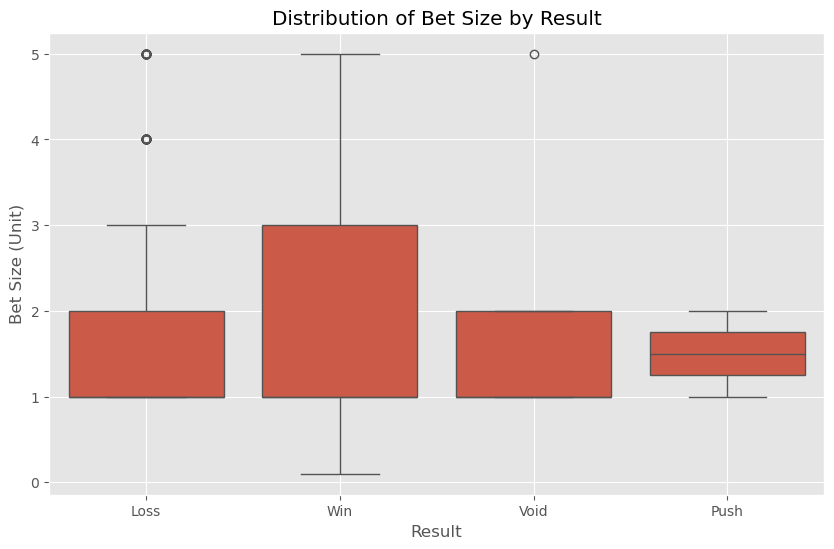

In [8]:
# Bet Size Distribution Across Different Outcomes

plt.figure(figsize=(10, 6))
sns.boxplot(x='Result', y='Unit', data=df)
plt.xlabel('Result')
plt.ylabel('Bet Size (Unit)')
plt.title('Distribution of Bet Size by Result')
plt.grid(True)
plt.show()

In [9]:
df['Win_Binary'] = (df['Result'] == 'Win').astype(int)
correlation = df[['Unit', 'Win_Binary']].corr().iloc[0, 1]
print(f"Correlation between Bet Size and Winning: {correlation:.2f}")

Correlation between Bet Size and Winning: 0.04


## Visualization

### P&L Over time

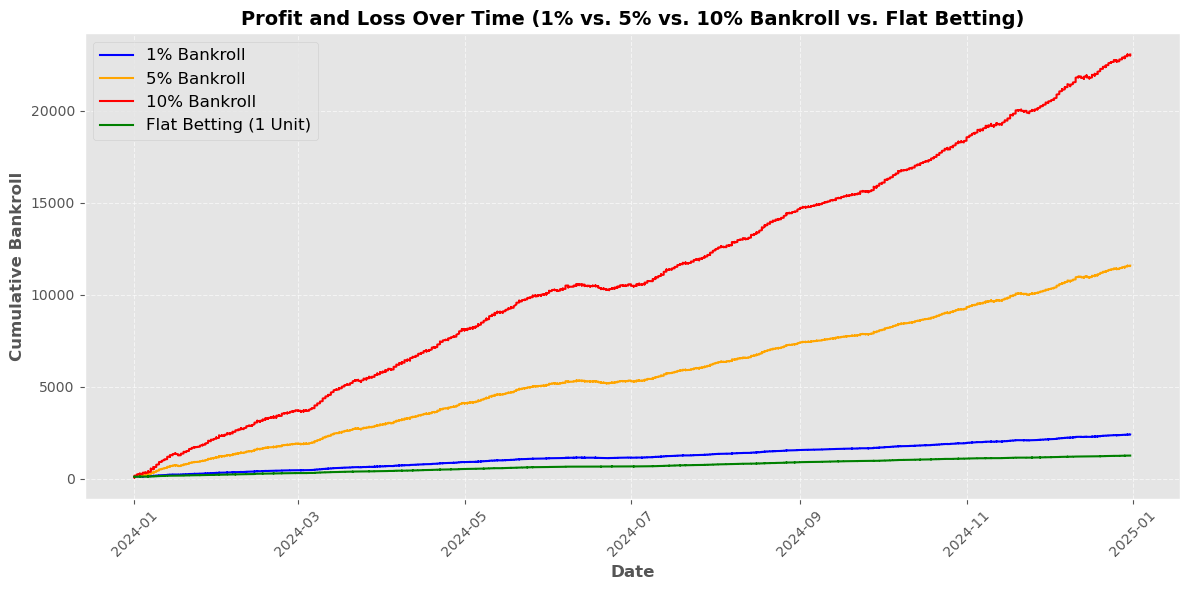

In [10]:
initial_bankroll = 100  

df['Extracted_Date'] = pd.to_datetime(df['Extracted_Date'])
df = df.sort_values('Extracted_Date')
df_filtered = df[df['Result'].isin(['Win', 'Loss'])].copy()

df_filtered['Bankroll_1%'] = df_filtered['Unit'] * 0.01 * initial_bankroll
df_filtered['Bankroll_5%'] = df_filtered['Unit'] * 0.05 * initial_bankroll
df_filtered['Bankroll_10%'] = df_filtered['Unit'] * 0.10 * initial_bankroll
df_filtered['Flat_Bet'] = 1  

df_filtered['Profit_Loss_1%'] = df_filtered.apply(lambda row: 
    (row['Bankroll_1%'] * (row['Odds'] - 1)) if row['Result'] == 'Win' else -row['Bankroll_1%'], axis=1)

df_filtered['Profit_Loss_5%'] = df_filtered.apply(lambda row: 
    (row['Bankroll_5%'] * (row['Odds'] - 1)) if row['Result'] == 'Win' else -row['Bankroll_5%'], axis=1)

df_filtered['Profit_Loss_10%'] = df_filtered.apply(lambda row: 
    (row['Bankroll_10%'] * (row['Odds'] - 1)) if row['Result'] == 'Win' else -row['Bankroll_10%'], axis=1)

df_filtered['Profit_Loss_Flat'] = df_filtered.apply(lambda row: 
    (row['Flat_Bet'] * (row['Odds'] - 1)) if row['Result'] == 'Win' else -row['Flat_Bet'], axis=1)

df_filtered['Cumulative_Bankroll_1%'] = initial_bankroll + df_filtered['Profit_Loss_1%'].cumsum()
df_filtered['Cumulative_Bankroll_5%'] = initial_bankroll + df_filtered['Profit_Loss_5%'].cumsum()
df_filtered['Cumulative_Bankroll_10%'] = initial_bankroll + df_filtered['Profit_Loss_10%'].cumsum()
df_filtered['Cumulative_Bankroll_Flat'] = initial_bankroll + df_filtered['Profit_Loss_Flat'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Extracted_Date'], df_filtered['Cumulative_Bankroll_1%'], 
         label="1% Bankroll", color='blue', linewidth=1.5, linestyle='-')
plt.plot(df_filtered['Extracted_Date'], df_filtered['Cumulative_Bankroll_5%'], 
         label="5% Bankroll", color='orange', linewidth=1.5, linestyle='-')
plt.plot(df_filtered['Extracted_Date'], df_filtered['Cumulative_Bankroll_10%'], 
         label="10% Bankroll", color='red', linewidth=1.5, linestyle='-')
plt.plot(df_filtered['Extracted_Date'], df_filtered['Cumulative_Bankroll_Flat'], 
         label="Flat Betting (1 Unit)", color='green', linewidth=1.5, linestyle='-')

plt.xlabel("Date", fontsize=12, fontweight='bold')
plt.ylabel("Cumulative Bankroll", fontsize=12, fontweight='bold')
plt.title("Profit and Loss Over Time (1% vs. 5% vs. 10% Bankroll vs. Flat Betting)", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

### Win-Loss heatmap

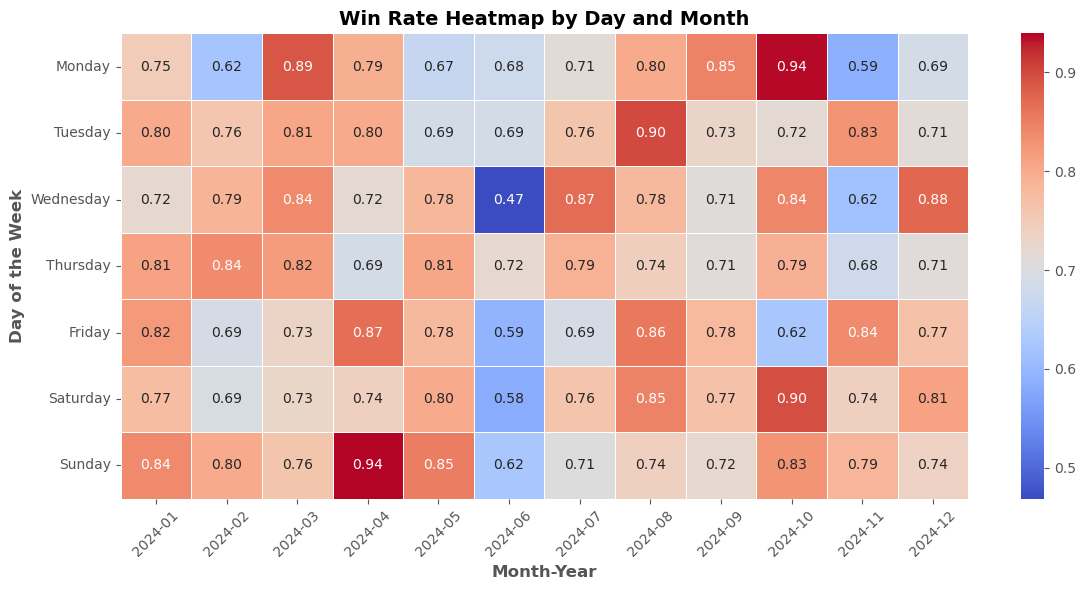

In [11]:
df['Extracted_Date'] = pd.to_datetime(df['Extracted_Date'])
df['YearMonth'] = df['Extracted_Date'].dt.to_period('M')  # Grouping by Year-Month

df['Win_Binary'] = df['Result'].map({'Win': 1, 'Loss': 0})  # Map Wins as 1, Losses as 0
win_loss_heatmap = df.pivot_table(index=df['Extracted_Date'].dt.weekday, 
                                  columns=df['Extracted_Date'].dt.to_period('M'), 
                                  values='Win_Binary', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(win_loss_heatmap, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, cbar=True)

plt.xlabel("Month-Year", fontsize=12, fontweight='bold')
plt.ylabel("Day of the Week", fontsize=12, fontweight='bold')
plt.title("Win Rate Heatmap by Day and Month", fontsize=14, fontweight='bold')

plt.yticks(ticks=np.arange(7) + 0.5, labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

plt.show()

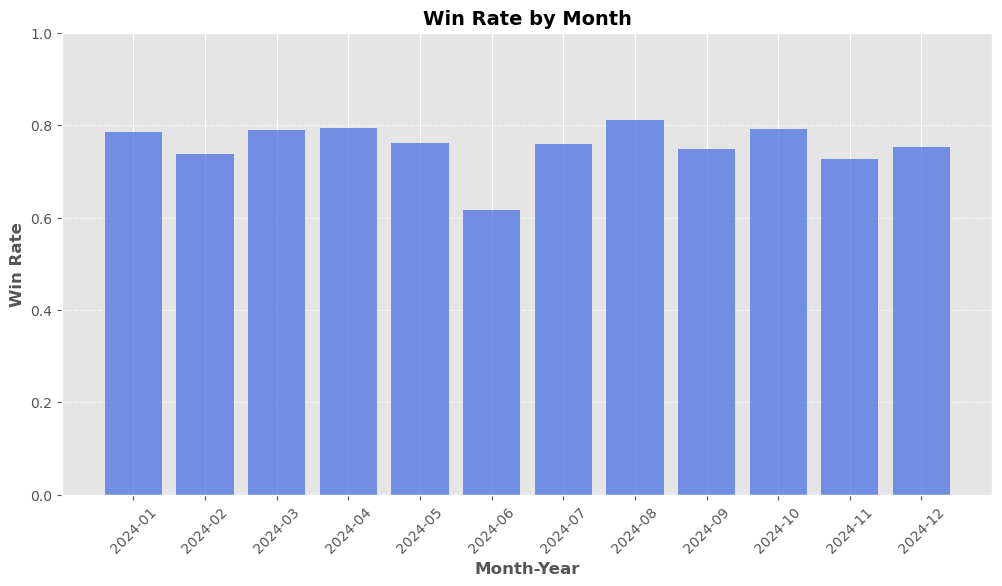

In [12]:
df['Extracted_Date'] = pd.to_datetime(df['Extracted_Date'], format='%d/%m/%Y')
df['YearMonth'] = df['Extracted_Date'].dt.to_period('M')  

# Calculate monthly win rate
monthly_win_rate = df.groupby('YearMonth')['Result'].apply(lambda x: (x == 'Win').mean()).reset_index(name='Win_Rate')

plt.figure(figsize=(12, 6))
plt.bar(monthly_win_rate['YearMonth'].astype(str), monthly_win_rate['Win_Rate'], color='royalblue', alpha=0.7)

plt.xlabel("Month-Year", fontsize=12, fontweight='bold')
plt.ylabel("Win Rate", fontsize=12, fontweight='bold')
plt.title("Win Rate by Month", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

## Statistical Test

### Chi-square Test

In [13]:
df['Extracted_Date'] = pd.to_datetime(df['Extracted_Date'], format='%d/%m/%Y')

contingency_sport = pd.crosstab(df['Sport'], df['Result'])

chi2_sport, p_sport, dof_sport, expected_sport = stats.chi2_contingency(contingency_sport)

print("Chi-Square Test Results for Sport vs. Win/Loss:")
print(f"Chi-Square Statistic: {chi2_sport:.2f}")
print(f"Degrees of Freedom: {dof_sport}")
print(f"P-Value: {p_sport:.4f}")

if p_sport < 0.05:
    print("Result: There is a significant relationship between Sport and Win/Loss.")
else:
    print("Result: No significant relationship between Sport and Win/Loss.")

Chi-Square Test Results for Sport vs. Win/Loss:
Chi-Square Statistic: 581.32
Degrees of Freedom: 1173
P-Value: 1.0000
Result: No significant relationship between Sport and Win/Loss.


In [14]:
df['Karma_Category'] = pd.cut(df['Comment_Karma'], bins=[-1, 50, 100, 200, float('inf')],
                              labels=['Low', 'Medium', 'High', 'Very High'])

contingency_karma = pd.crosstab(df['Karma_Category'], df['Result'])

chi2_karma, p_karma, dof_karma, expected_karma = stats.chi2_contingency(contingency_karma)

print("\nChi-Square Test Results for Karma Category vs. Win/Loss:")
print(f"Chi-Square Statistic: {chi2_karma:.2f}")
print(f"Degrees of Freedom: {dof_karma}")
print(f"P-Value: {p_karma:.4f}")

if p_karma < 0.05:
    print("Result: There is a significant relationship between Karma Category and Win/Loss.")
else:
    print("Result: No significant relationship between Karma Category and Win/Loss.")


Chi-Square Test Results for Karma Category vs. Win/Loss:
Chi-Square Statistic: 17.54
Degrees of Freedom: 9
P-Value: 0.0409
Result: There is a significant relationship between Karma Category and Win/Loss.


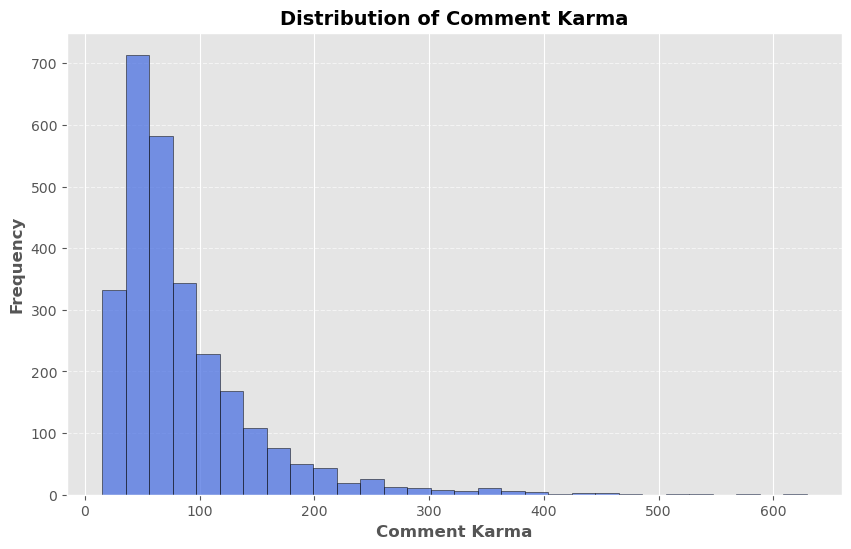

In [15]:
# Plot the distribution of Comment Karma
plt.figure(figsize=(10, 6))
plt.hist(df['Comment_Karma'], bins=30, color='royalblue', alpha=0.7, edgecolor='black')

plt.xlabel("Comment Karma", fontsize=12, fontweight='bold')
plt.ylabel("Frequency", fontsize=12, fontweight='bold')
plt.title("Distribution of Comment Karma", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

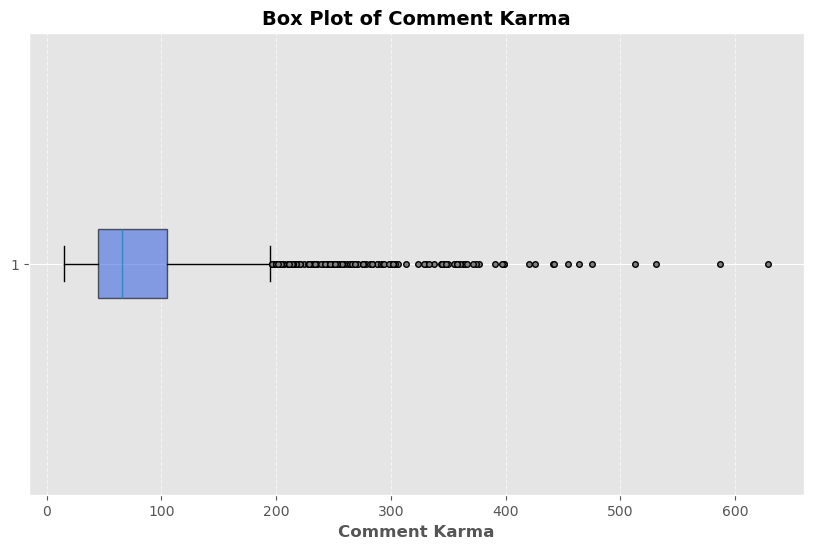

Minimum Comment Karma: 15
Maximum Comment Karma: 629
Median Comment Karma: 66.0


In [16]:
# Create a box plot for Comment Karma without log transformation
plt.figure(figsize=(10, 6))
plt.boxplot(df['Comment_Karma'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='royalblue', alpha=0.6), 
            flierprops=dict(marker='o', markersize=4, markerfacecolor='grey', markeredgecolor='black'))

plt.xlabel("Comment Karma", fontsize=12, fontweight='bold')
plt.title("Box Plot of Comment Karma", fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

# Compute statistics
karma_min = df['Comment_Karma'].min()
karma_max = df['Comment_Karma'].max()
karma_median = df['Comment_Karma'].median()

print(f"Minimum Comment Karma: {karma_min}")
print(f"Maximum Comment Karma: {karma_max}")
print(f"Median Comment Karma: {karma_median}")

In [38]:
percentiles = np.percentile(df['Comment_Karma'], [25, 50, 75, 90, 100])

# Define bins based on computed percentiles
bins = [15, percentiles[0], percentiles[1], percentiles[2], percentiles[3], 629]  # Min to Max range
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Apply new karma classification
df['Karma_Category'] = pd.cut(df['Comment_Karma'], bins=bins, labels=labels, include_lowest=True)

# Display the new category distribution
print(df['Karma_Category'].value_counts())

print("\n")
print("Karma Ranges per Category:")
print(f"{'Category':<12} | {'Lower Bound':>11} | {'Upper Bound':>11}")
print("-" * 39)
for lbl, lower, upper in zip(labels, bins[:-1], bins[1:]):
    print(f"{lbl:<12} | {lower:>11.2f} | {upper:>11.2f}")



Karma_Category
Very Low     720
Medium       686
Low          670
High         416
Very High    268
Name: count, dtype: int64


Karma Ranges per Category:
Category     | Lower Bound | Upper Bound
---------------------------------------
Very Low     |       15.00 |       45.00
Low          |       45.00 |       66.00
Medium       |       66.00 |      105.00
High         |      105.00 |      161.00
Very High    |      161.00 |      629.00


Karma_Category
Very Low     720
Medium       686
Low          670
High         416
Very High    268
Name: count, dtype: int64

------------- Karma Win Rate Data -------------
  Karma_Category    Result   Avg_Karma  Karma_to_Win_Ratio
0       Very Low  0.777778   35.206944           27.383179
1            Low  0.735821   55.734328           41.010483
2         Medium  0.755102   82.918367           62.611828
3           High  0.711538  129.122596           91.875693
4      Very High  0.820896  236.320896          193.994765
-----------------------------------------------

Optimal Karma Category for Betting: Very High
Win Rate: 82.09%
Average Karma in Category: 236.32
Karma-to-Win Ratio: 193.994765


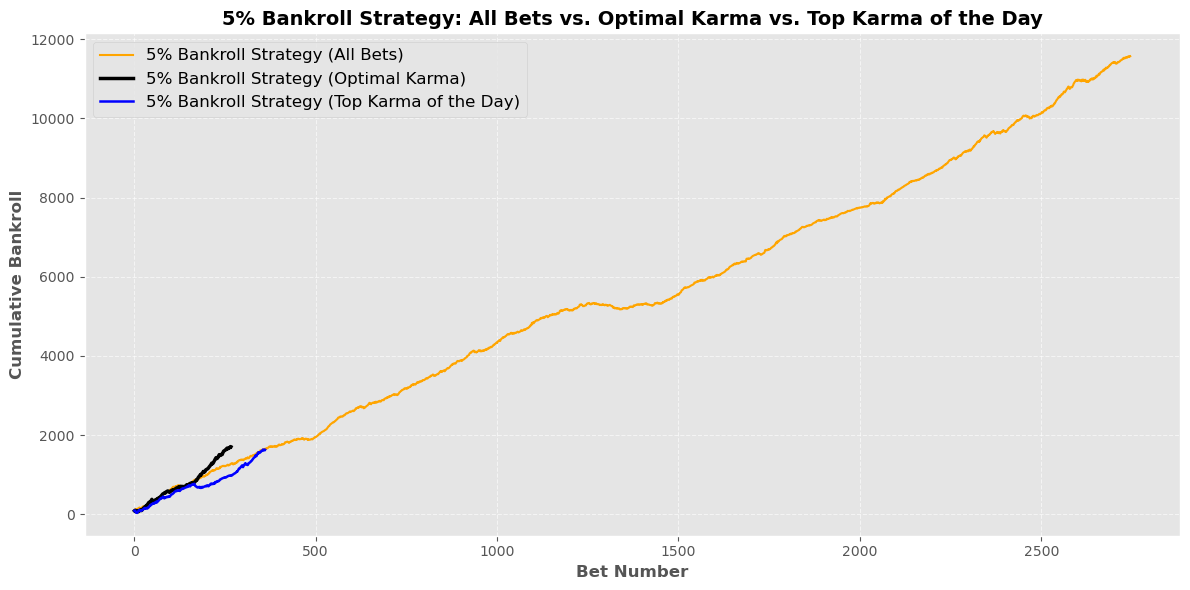


------------- Starting & Ending Balances -------------
All Bets (5% Bankroll) => Start: 85.00 | End: 11573.75
Optimal Karma (5% Bankroll) => Start: 85.00 | End: 1702.35
Top Karma of the Day (5% Bankroll) => Start: 85.00 | End: 1628.40
-------------------------------------------------------


In [32]:
# ---------------------- KARMA BINNING ----------------------
percentiles = np.percentile(df['Comment_Karma'], [25, 50, 75, 90, 100])

# Define bins based on computed percentiles
bins = [15, percentiles[0], percentiles[1], percentiles[2], percentiles[3], 629]  # from min to max range
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Apply new karma classification
df['Karma_Category'] = pd.cut(df['Comment_Karma'], bins=bins, labels=labels, include_lowest=True)

# Display the new category distribution
print(df['Karma_Category'].value_counts())

initial_bankroll = 100  

df['Extracted_Date'] = pd.to_datetime(df['Extracted_Date'])
df = df.sort_values('Extracted_Date')

# ---------------------- FIND OPTIMAL KARMA CATEGORY ----------------------
# For the example, let's build a mock 'karma_win_rate' DataFrame
# In your real code, you should have a DataFrame that calculates 'Karma_to_Win_Ratio', 'Avg_Karma', etc.
karma_win_rate = (
    df.groupby('Karma_Category', observed=False)  # Explicitly set observed=False to avoid the FutureWarning
      .agg(
          Result=('Result', lambda x: (x == 'Win').mean()),  # Win Rate
          Avg_Karma=('Comment_Karma', 'mean')
      )
      .reset_index()
)

# Create a mock 'Karma_to_Win_Ratio' for demonstration. In your code, you'd compute it as you wish.
karma_win_rate['Karma_to_Win_Ratio'] = karma_win_rate['Avg_Karma'] * karma_win_rate['Result']

optimal_karma_category = karma_win_rate.sort_values(by='Karma_to_Win_Ratio', ascending=False).iloc[0]

print("\n------------- Karma Win Rate Data -------------")
print(karma_win_rate)
print("-----------------------------------------------")

print(f"\nOptimal Karma Category for Betting: {optimal_karma_category['Karma_Category']}")
print(f"Win Rate: {optimal_karma_category['Result']:.2%}")
print(f"Average Karma in Category: {optimal_karma_category['Avg_Karma']:.2f}")
print(f"Karma-to-Win Ratio: {optimal_karma_category['Karma_to_Win_Ratio']:.6f}")

# ---------------------- BETTING SIMULATION FOR ALL BETS (5% BANKROLL) ----------------------
df_filtered = df[df['Result'].isin(['Win', 'Loss'])].copy()
df_filtered['Bet_Number'] = range(1, len(df_filtered) + 1)
df_filtered['Bankroll_5%'] = df_filtered['Unit'] * 0.05 * initial_bankroll

df_filtered['Profit_Loss_5%'] = df_filtered.apply(
    lambda row: (row['Bankroll_5%'] * (row['Odds'] - 1)) if row['Result'] == 'Win' else -row['Bankroll_5%'],
    axis=1
)

df_filtered['Cumulative_Bankroll_5%'] = initial_bankroll + df_filtered['Profit_Loss_5%'].cumsum()

# ---------------------- BETTING SIMULATION FOR OPTIMAL KARMA (5% BANKROLL) ----------------------
df_optimal = df[df['Karma_Category'] == optimal_karma_category['Karma_Category']].copy()
df_optimal = df_optimal[df_optimal['Result'].isin(['Win', 'Loss'])]  # Ensure only Win/Loss bets
df_optimal = df_optimal.sort_values('Extracted_Date')
df_optimal['Bet_Number'] = range(1, len(df_optimal) + 1)
df_optimal['Bankroll_5%'] = df_optimal['Unit'] * 0.05 * initial_bankroll

df_optimal['Profit_Loss_5%'] = df_optimal.apply(
    lambda row: (row['Bankroll_5%'] * (row['Odds'] - 1)) if row['Result'] == 'Win' else -row['Bankroll_5%'],
    axis=1
)

df_optimal['Cumulative_Bankroll_5%'] = initial_bankroll + df_optimal['Profit_Loss_5%'].cumsum()

# ---------------------- BETTING SIMULATION FOR TOP KARMA OF THE DAY (5% BANKROLL) ----------------------
df['Day'] = df['Extracted_Date'].dt.date
df_top_karma = df.loc[df.groupby('Day')['Comment_Karma'].idxmax()]  # Get the top karma bettor per day
df_top_karma = df_top_karma[df_top_karma['Result'].isin(['Win', 'Loss'])].copy()
df_top_karma = df_top_karma.sort_values('Extracted_Date')
df_top_karma['Bet_Number'] = range(1, len(df_top_karma) + 1)
df_top_karma['Bankroll_5%'] = df_top_karma['Unit'] * 0.05 * initial_bankroll

df_top_karma['Profit_Loss_5%'] = df_top_karma.apply(
    lambda row: (row['Bankroll_5%'] * (row['Odds'] - 1)) if row['Result'] == 'Win' else -row['Bankroll_5%'],
    axis=1
)

df_top_karma['Cumulative_Bankroll_5%'] = initial_bankroll + df_top_karma['Profit_Loss_5%'].cumsum()

# ---------------------- PLOT RESULTS ----------------------
plt.figure(figsize=(12, 6))

# Plot the 5% Bankroll strategy for ALL bets
plt.plot(df_filtered['Bet_Number'], df_filtered['Cumulative_Bankroll_5%'],
         label="5% Bankroll Strategy (All Bets)",
         color='orange', linewidth=1.5, linestyle='-')

# Plot the 5% Bankroll strategy for the Optimal Karma category
plt.plot(df_optimal['Bet_Number'], df_optimal['Cumulative_Bankroll_5%'],
         label="5% Bankroll Strategy (Optimal Karma)",
         color='black', linewidth=2.5, linestyle='-')

# Plot the 5% Bankroll strategy for the Top Karma of the Day
plt.plot(df_top_karma['Bet_Number'], df_top_karma['Cumulative_Bankroll_5%'],
         label="5% Bankroll Strategy (Top Karma of the Day)",
         color='blue', linewidth=1.8, linestyle='-')

plt.xlabel("Bet Number", fontsize=12, fontweight='bold')
plt.ylabel("Cumulative Bankroll", fontsize=12, fontweight='bold')
plt.title("5% Bankroll Strategy: All Bets vs. Optimal Karma vs. Top Karma of the Day",
          fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

# ---------------------- PRINT START AND ENDING BALANCE FOR EACH STRATEGY ----------------------
def print_start_end_balance(label, df_strategy):
    if not df_strategy.empty:
        start_balance = df_strategy['Cumulative_Bankroll_5%'].iloc[0]
        end_balance = df_strategy['Cumulative_Bankroll_5%'].iloc[-1]
        print(f"{label} => Start: {start_balance:.2f} | End: {end_balance:.2f}")
    else:
        print(f"{label} => No bets placed.")

print("\n------------- Starting & Ending Balances -------------")
print_start_end_balance("All Bets (5% Bankroll)", df_filtered)
print_start_end_balance("Optimal Karma (5% Bankroll)", df_optimal)
print_start_end_balance("Top Karma of the Day (5% Bankroll)", df_top_karma)
print("-------------------------------------------------------")

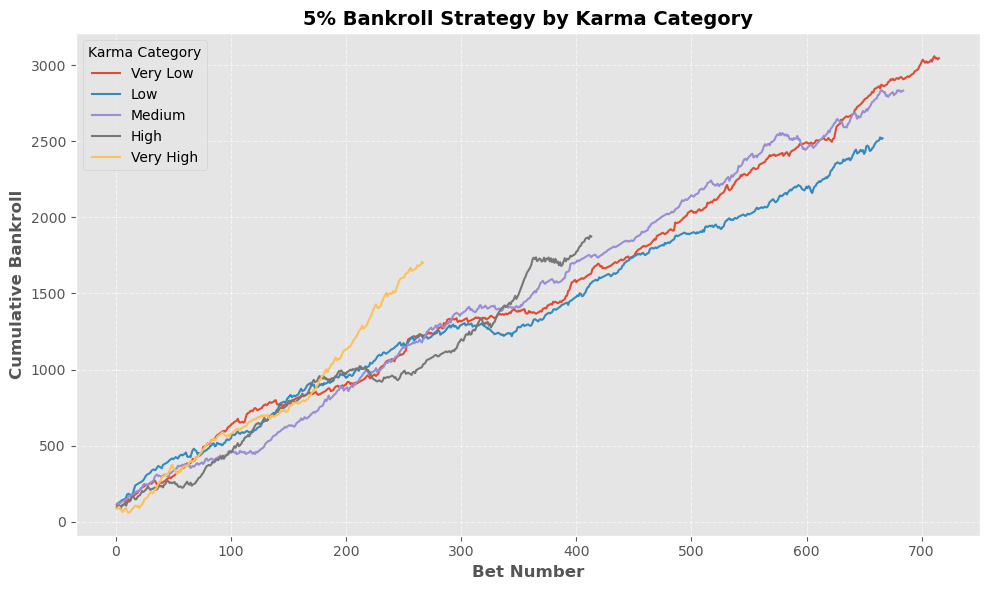


------ Starting & Ending Balances (Full) ------
Very Low   => Overall => Start:   90.00 | End: 3045.50 | Bets: 715
Low        => Overall => Start:  113.65 | End: 2519.25 | Bets: 666
Medium     => Overall => Start:  115.25 | End: 2832.25 | Bets: 684
High       => Overall => Start:  104.00 | End: 1874.40 | Bets: 413
Very High  => Overall => Start:   85.00 | End: 1702.35 | Bets: 267
------------------------------------------------

------ Starting & Ending Balances (First 250 Bets) ------
Very Low   => First 250 Bets => Start:   90.00 | End: 1104.40
Low        => First 250 Bets => Start:  113.65 | End: 1173.45
Medium     => First 250 Bets => Start:  115.25 | End: 1152.10
High       => First 250 Bets => Start:  104.00 | End:  987.75
Very High  => First 250 Bets => Start:   85.00 | End: 1606.40
--------------------------------------------------------------


In [40]:
import matplotlib.pyplot as plt

# Only keep Win/Loss bets for the simulation
df_filtered = df[df['Result'].isin(['Win', 'Loss'])].copy()

initial_bankroll = 100  # starting bankroll
category_data = {}

# ---------------------- BETTING SIMULATIONS PER KARMA CATEGORY ----------------------
for category in labels:
    # Get all bets within this Karma Category
    df_cat = df_filtered[df_filtered['Karma_Category'] == category].copy()
    
    if df_cat.empty:
        # No bets in this category
        category_data[category] = None
        continue
    
    df_cat = df_cat.sort_values('Extracted_Date')
    df_cat['Bet_Number'] = range(1, len(df_cat) + 1)
    
    # 5% of initial bankroll for each bet, scaled by 'Unit'
    df_cat['Bankroll_5%'] = df_cat['Unit'] * 0.05 * initial_bankroll
    
    # Calculate profit/loss per bet
    df_cat['Profit_Loss_5%'] = df_cat.apply(
        lambda row: (row['Bankroll_5%'] * (row['Odds'] - 1)) if row['Result'] == 'Win' else -row['Bankroll_5%'],
        axis=1
    )
    
    # Cumulative bankroll over time
    df_cat['Cumulative_Bankroll_5%'] = initial_bankroll + df_cat['Profit_Loss_5%'].cumsum()
    
    category_data[category] = df_cat

# ---------------------- PLOT RESULTS ----------------------
plt.figure(figsize=(10, 6))

for category, df_cat in category_data.items():
    if df_cat is not None:
        plt.plot(
            df_cat['Bet_Number'], 
            df_cat['Cumulative_Bankroll_5%'], 
            label=f"{category}",
            linewidth=1.5
        )

plt.title("5% Bankroll Strategy by Karma Category", fontsize=14, fontweight='bold')
plt.xlabel("Bet Number", fontsize=12, fontweight='bold')
plt.ylabel("Cumulative Bankroll", fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Karma Category", fontsize=10)
plt.tight_layout()
plt.show()

# ---------------------- PRINT START AND ENDING BALANCE FOR EACH CATEGORY ----------------------
def print_start_end_balance(category, df_cat):
    if df_cat is not None and not df_cat.empty:
        start_balance = df_cat['Cumulative_Bankroll_5%'].iloc[0]
        end_balance = df_cat['Cumulative_Bankroll_5%'].iloc[-1]
        total_bets = len(df_cat)
        print(f"{category:<10} => Overall => Start: {start_balance:7.2f} | End: {end_balance:7.2f} | Bets: {total_bets}")
    else:
        print(f"{category:<10} => No bets placed.")

print("\n------ Starting & Ending Balances (Full) ------")
for category in labels:
    print_start_end_balance(category, category_data[category])
print("------------------------------------------------")

# ---------------------- PRINT START/END BALANCE FOR FIRST 250 BETS PER CATEGORY ----------------------
N_BETS = 250

def print_partial_balance(category, df_cat, n_bets):
    """
    Prints the start and end bankroll for the first n_bets in df_cat.
    If df_cat has fewer than n_bets, it uses the full length of df_cat.
    """
    if df_cat is not None and not df_cat.empty:
        partial_df = df_cat.iloc[:n_bets]  # up to row index n_bets
        start_balance = partial_df['Cumulative_Bankroll_5%'].iloc[0]
        end_balance = partial_df['Cumulative_Bankroll_5%'].iloc[-1]
        used_bets = len(partial_df)
        print(f"{category:<10} => First {used_bets:3d} Bets => Start: {start_balance:7.2f} | End: {end_balance:7.2f}")
    else:
        print(f"{category:<10} => No bets placed.")

print(f"\n------ Starting & Ending Balances (First {N_BETS} Bets) ------")
for category in labels:
    print_partial_balance(category, category_data[category], N_BETS)
print("--------------------------------------------------------------")


## Cappers

### Most profitable users

In [18]:
df_filtered = df[df['Result'].isin(['Win', 'Loss'])].copy()

df_filtered['Profit'] = df_filtered.apply(lambda row: 
    (row['Unit'] * (row['Odds'] - 1)) if row['Result'] == 'Win' else -row['Unit'], axis=1)

author_profit = df_filtered.groupby('Comment_Author')['Profit'].sum().reset_index()

author_profit = author_profit.sort_values(by='Profit', ascending=False)

print(author_profit.head(25))


          Comment_Author  Profit
70               Deleted  260.03
357     itachiuchiha2255  190.22
173   MajorLeagueGambler   81.03
380   major-couch-potato   66.51
66         Defiant-Degen   60.22
143    JoeInglesOfficial   51.58
182            MrBets365   50.50
263       ThatOneCinaGuy   49.67
111     Good_Stable_7381   43.30
401             polo0509   42.65
80           Egolifter01   40.55
309         billycapezzi   38.75
67          DefiantDegen   33.59
13             AdamIotti   31.59
215      Real_League2972   29.78
104           GMONEYOHIO   27.70
89        EthicalGambler   26.69
171     Low_Platform9191   25.90
144       JoelBarish-ish   23.59
81     ElProductoSeCuida   22.45
132     InconsolableBrat   22.34
187  Narrow-Sympathy8470   20.60
331            doggypede   19.64
112          GrampaJim64   19.26
432       therealchutton   18.70
